## Bytes

In [4]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
zip_path = '../data/cleaned/data_cleaned.zip'
folder_extract = '../data/temp_extracted'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(folder_extract)

In [3]:
df_train = pd.read_csv('../data/temp_extracted/train.csv')
df_test = pd.read_csv('../data/temp_extracted/test.csv')

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class BytesAnalyzer:
    def __init__(self):
        self.fence_high = None

    def clean_and_convert(self, df, col='bytes'):
        df_bytes = df[['index', col]].copy()
        df_bytes[col] = pd.to_numeric(df_bytes[col], errors='coerce').fillna(0)
        df_bytes[col] = df_bytes[col] / 1000 # Sang KB
        return df_bytes

    def get_stats(self, df_subset, col='bytes'):
        """Hàm hỗ trợ tính nhanh các thông số thống kê"""
        if df_subset.empty: return None
        return {
            'mean': df_subset[col].mean(),
            'median': df_subset[col].median(),
            'mode': df_subset[col].mode()[0] if not df_subset[col].mode().empty else 0,
            'max': df_subset[col].max()
        }

    def categorize_bytes(self, df, col='bytes'):
        """Phân loại dữ liệu dựa trên ngưỡng đã tính"""
        if self.fence_high is None:
            self.calculate_outlier_threshold(df, col)
            
        df['bytesaction'] = np.where(df[col] <= self.fence_high, 'normal', 'for observation')
        return df

    def plot_normal_distribution(self, df, title_prefix="Data", col='bytes'):
        """BIỂU ĐỒ 1: Phân phối dữ liệu bình thường (Boxplot + Histplot)"""
        # Tính toán ngưỡng nếu chưa có
        df_return = df[df[col] > 0]
        q1, q3 = df_return[col].quantile([0.25, 0.75])
        self.fence_high = q3 + (1.5 * (q3 - q1))
        
        # Lọc dữ liệu bình thường
        df_normal = df_return[df_return[col] <= self.fence_high]
        s = self.get_stats(df_normal, col)

        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20, 7), 
                                              gridspec_kw={"height_ratios": (0.2, 1)})
        
        sns.boxplot(data=df_normal, x=col, ax=ax_box, showfliers=False)
        sns.histplot(df_normal[col], bins=100, kde=True, ax=ax_hist)
        
        # Vẽ các đường Mode, Mean, Median, Max
        ax_hist.axvline(s['mean'], color='b', linestyle='--', label=f"mean ({s['mean']:.2f} kb)")
        ax_hist.axvline(s['median'], color='g', linestyle='-', label=f"median ({s['median']:.2f} kb)")
        ax_hist.axvline(s['mode'], color='r', linestyle='-', label=f"mode ({s['mode']:.2f} kb)")
        ax_hist.axvline(s['max'], color='gray', linestyle='--', label=f"max ({s['max']:.2f} kb)")
        
        ax_box.set_title(f'{title_prefix} - Bytes distribution without outliers')
        plt.legend()
        plt.show()

    def plot_outliers_scatter(self, df, title_prefix="Data", col='bytes'):
        """BIỂU ĐỒ 2: Scatter plot cho các giá trị Outliers"""
        if self.fence_high is None: return print("Hãy chạy plot_normal_distribution trước!")

        df_outliers = df[df[col] > self.fence_high].copy()
        if df_outliers.empty: return print("Không có Outliers để vẽ.")
        
        s = self.get_stats(df_outliers, col)
        
        # Gom nhóm để lấy count cho trục Y (giống trong ảnh bạn gửi)
        df_counts = df_outliers.groupby(col)[col].count().reset_index(name='count')

        plt.figure(figsize=(20, 6))
        sns.scatterplot(data=df_counts, x=col, y='count')
        
        # Vẽ các đường thống kê cho riêng nhóm Outlier
        plt.axvline(s['mean'], color='b', linestyle='--', label=f"mean ({s['mean']:.2f} kb)")
        plt.axvline(s['median'], color='g', linestyle='-', label=f"median ({s['median']:.2f} kb)")
        plt.axvline(s['mode'], color='r', linestyle='-', label=f"mode ({s['mode']:.2f} kb)")
        plt.axvline(s['max'], color='gray', linestyle='--', label=f"max ({s['max']:.2f} kb)")
        
        plt.title(f"{title_prefix} - Outliers Scatter Analysis")
        plt.xlabel("kilobytes")
        plt.ylabel("count")
        plt.legend()
        plt.show()

In [19]:
def analyze_bytes_workflow(df, name):
    print(f"--- Analyzing Bytes for {name} Set ---")
    
    analyzer = BytesAnalyzer()
    
    df_bytes = analyzer.clean_and_convert(df)
    
    analyzer.plot_normal_distribution(df_bytes, title_prefix=name)
    analyzer.plot_outliers_scatter(df_bytes, title_prefix=name)

    df_final = analyzer.categorize_bytes(df_bytes)
    
    return df_final


--- Analyzing Bytes for Train Set ---


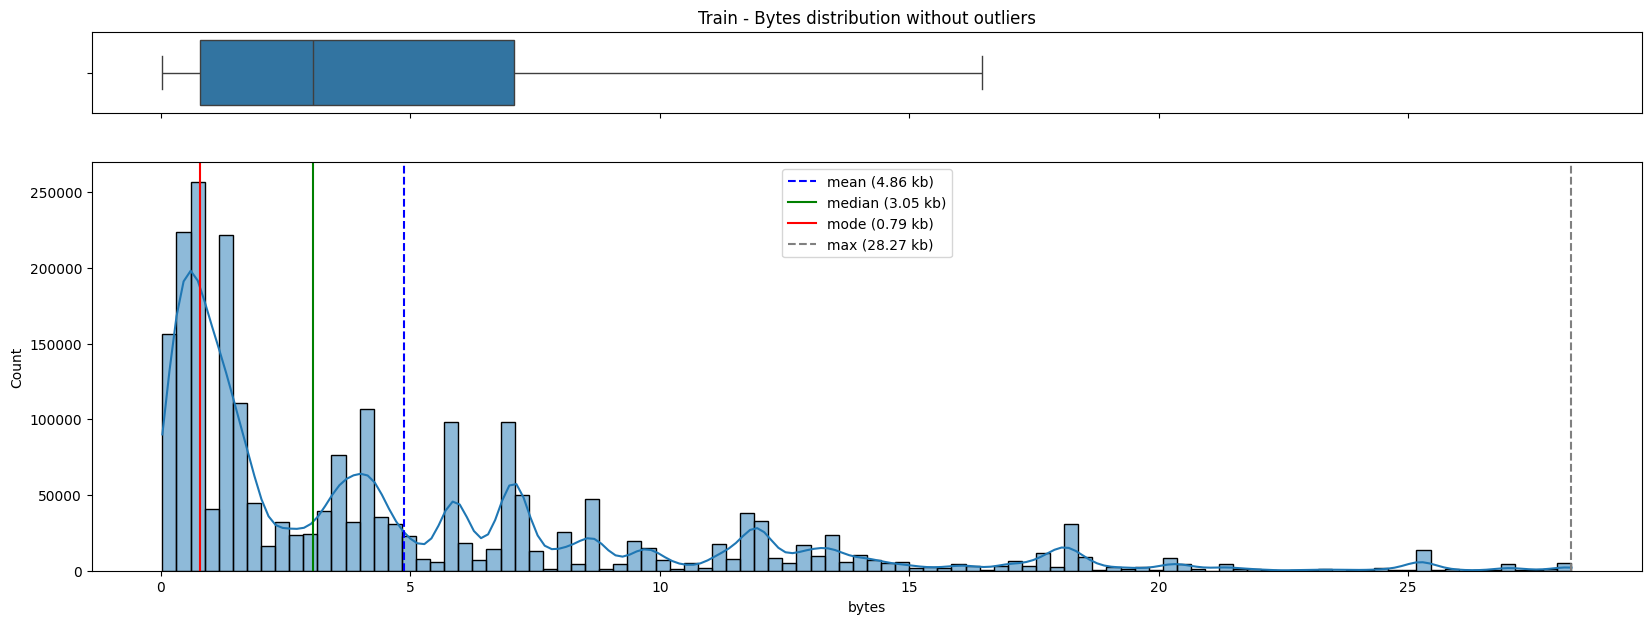

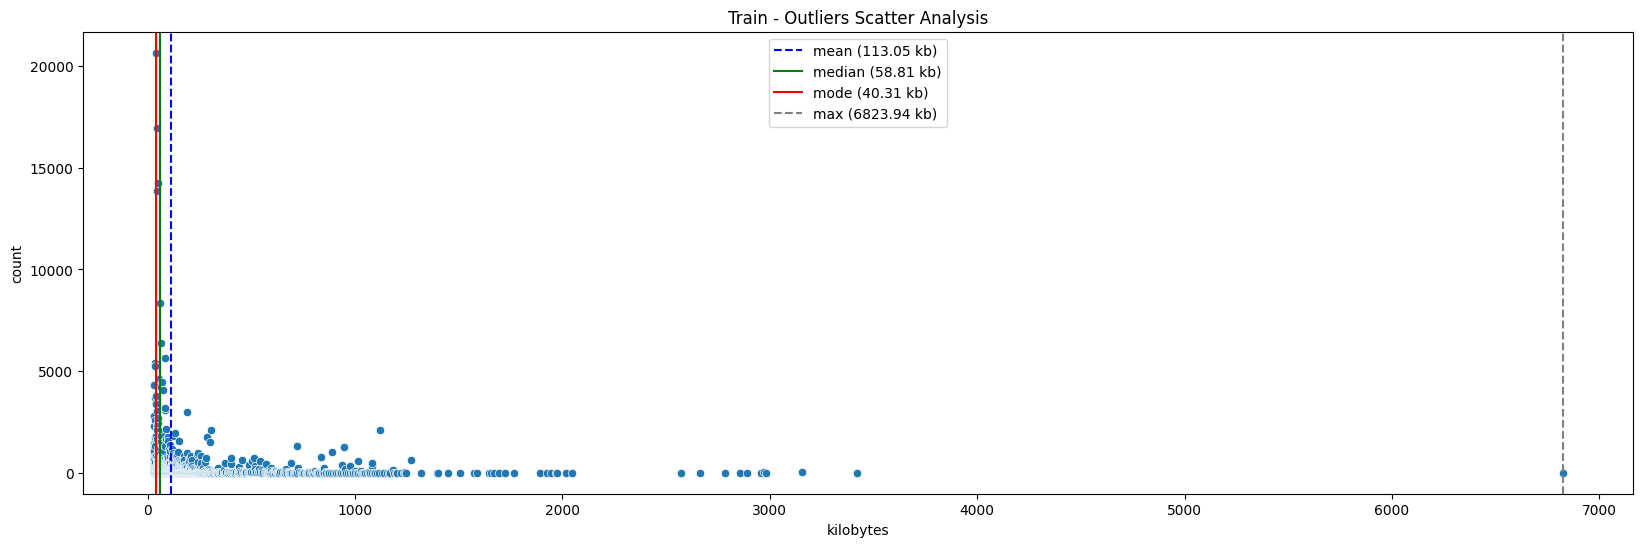

,index,bytes,bytesaction
0,0,6.245,normal
1,1,3.985,normal
2,2,4.085,normal
3,3,0.000,normal
4,4,4.179,normal
...,...,...,...
2934925,2934925,5.866,normal
2934926,2934926,0.786,normal
2934927,2934927,0.363,normal
2934928,2934928,0.234,normal


In [24]:

df_train_bytes = analyze_bytes_workflow(df_train, "Train")
df_train_bytes

--- Analyzing Bytes for Test Set ---


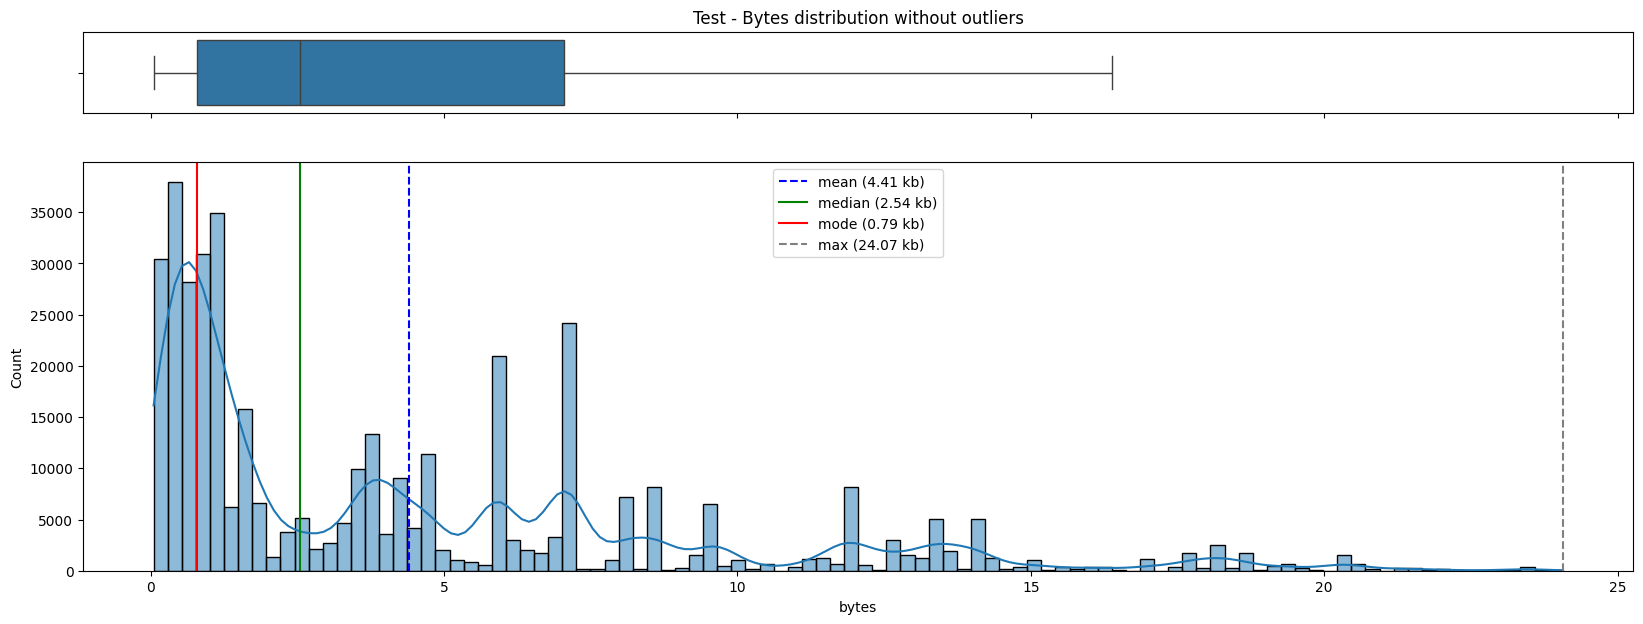

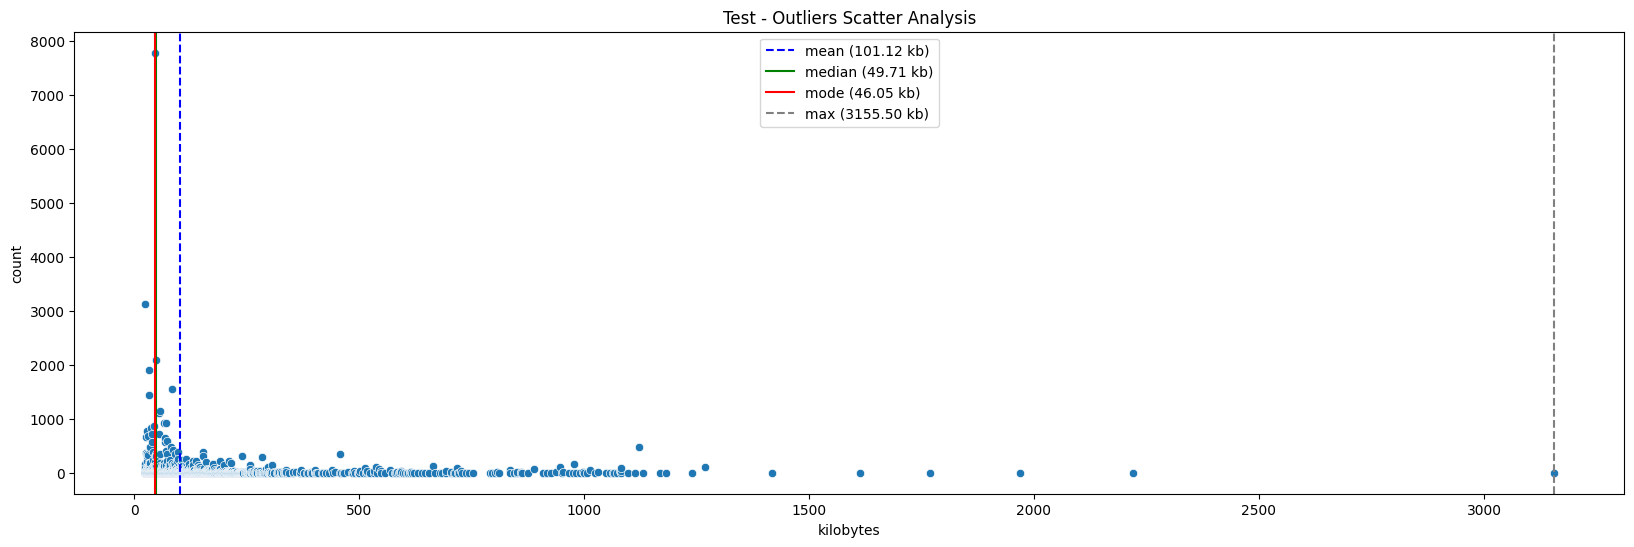

,index,bytes,bytesaction
0,0,7.087,normal
1,1,1.292,normal
2,2,5.866,normal
3,3,1.625,normal
4,4,0.000,normal
...,...,...,...
526639,526639,0.000,normal
526640,526640,0.000,normal
526641,526641,57.344,for observation
526642,526642,0.515,normal


In [25]:
df_test_bytes = analyze_bytes_workflow(df_test, "Test")
df_test_bytes